In [1]:
import torch
import torch.nn as nn
import scipy.io as sio
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import os
import pickle
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from Loss import LossDegree

In [2]:
class MyANN(nn.Module):
    def __init__(self, input_size, hidden_layer, hidden_size, output_size):
        """
        
        :param input_size: 
        :param hidden_layer: 
        :param hidden_size: 
        :param output_size: 
        """
        super(MyANN, self).__init__()

        self.input_size = input_size
        self.hidden_layer = hidden_layer
        self. hidden_size = hidden_size
        self.output_size = output_size
        # 构体模型
        self.model = self.get_model_structure()

    def get_model_structure(self):
        """
        根据input_size, hidden_layer, hidden_size, output_size构建模型结构
        """
        layer_list = []
        # input到hidden
        layer_list.append(nn.Linear(self.input_size, self.hidden_size))
        layer_list.append(nn.LeakyReLU())
        #layer_list.append(nn.Sigmoid())

        for i in range(self.hidden_layer - 1):
            layer_list.append(nn.Linear(self.hidden_size, self.hidden_size))
            #layer_list.append(nn.Sigmoid())
            layer_list.append(nn.LeakyReLU())

        layer_list.append(nn.Linear(self.hidden_size, self.output_size))

        model = nn.Sequential(*layer_list)
        return model

    def forward(self, x):
        """

        """
        output = self.model(x)
        return output

In [3]:
# 加载数据--feature
with open('../data_target_01/target_model.pkl', 'rb') as f:
    dataset_feature = pickle.load(f)
print(dataset_feature.keys())

dict_keys(['uwnd', 'vwnd', 'temp', 'hght', 'rhum', 'lspe', 'sstk', 't2mm', 'u10m', 'v10m', 'visi', 't2md', 'cape', 'velocity10m', 'degree10m'])


In [4]:
# 加载数据--label
with open('../data_target_01/target_observation.pkl', 'rb') as f:
    real_target = pickle.load(f)
print(real_target.keys())

dict_keys(['velocity', 'degree', 'temp', 'rain'])


In [5]:
label_velocity = real_target['velocity'].reshape((-1,1))
label_temp = real_target['temp'].reshape((-1,1))

In [6]:
label_velocity.shape, label_temp.shape

((2680, 1), (2680, 1))

In [7]:
# 提取数据##############################################
velocity10m = dataset_feature['velocity10m']
vwnd = dataset_feature['vwnd']

In [8]:
##########################################
feature = np.column_stack((velocity10m, vwnd))
feature.shape

(2680, 2)

In [9]:
# 归一化参数
feature_min = np.min(feature, axis=0)
feature_max = np.max(feature, axis=0)
# 归一化
feature = (feature - feature_min) / (feature_max - feature_min)

In [10]:
sample_num, feature_num = feature.shape

In [11]:
# 训练数据转为tensor对象
feature_target = torch.from_numpy(feature).to(torch.float32)
label_target = torch.from_numpy(label_velocity).to(torch.float32)#################################

In [12]:
# 时间
with open('../data_target_01/target_time_axis.pkl', 'rb') as f:
    axis = pickle.load(f)
real_time = axis.to_numpy().reshape(-1,1)

In [13]:
real_time.shape

(2680, 1)

In [14]:
# 划分数据集
feature_train = feature_target[:round(0.7*sample_num),:]
label_train = label_target[:round(0.7*sample_num),:]
time_train = real_time[:round(0.7*sample_num)]

feature_val = feature_target[round(0.7*sample_num):round(0.8*sample_num),:]
label_val = label_target[round(0.7*sample_num):round(0.8*sample_num),:]
time_val = real_time[round(0.7*sample_num):round(0.8*sample_num)]

feature_test = feature_target[round(0.8*sample_num):,:]
label_test = label_target[round(0.8*sample_num):,:]
time_test = real_time[round(0.8*sample_num):]

In [15]:
# 保存 训练 和 测试 数据集
parameter_dict_norm = {'feature_min': feature_min, 'feature_max': feature_max}
data_dict_train = {'feature_train': feature_train.numpy(),
                   'label_train': label_train.numpy(),
                   'time_train': time_train}
data_dict_test = {'feature_test': feature_test.numpy(),
                   'label_test': label_test.numpy(),
                   'time_test': time_test}

######################################
sio.savemat('../data_model_target_01/BP_velocity/parameter_norm.mat', parameter_dict_norm)
sio.savemat('../data_model_target_01/BP_velocity/dataset_train.mat', data_dict_train)
sio.savemat('../data_model_target_01/BP_velocity/dataset_test.mat', data_dict_test)

In [16]:
print(feature_train.shape, label_train.shape, feature_val.shape, label_val.shape, feature_test.shape, label_test.shape)

torch.Size([1876, 2]) torch.Size([1876, 1]) torch.Size([268, 2]) torch.Size([268, 1]) torch.Size([536, 2]) torch.Size([536, 1])


In [17]:
# 编写训练逻辑

def training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train, feature_val, label_val):
    """

    """
    # 选择模型
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # 移动到device上运算
    model.to(device)
    feature_train = feature_train.to(device)
    label_train = label_train.to(device)
    feature_val = feature_val.to(device)
    label_val = label_val.to(device)

    # 初始化上一轮的loss_train
    loss_train_previous = 0
    for epoch in range(1, n_epochs + 1):

        predict_train = model(feature_train)
        loss_train = loss_fn(predict_train, label_train)

        optimizer.zero_grad()
        loss_train.backward()

        optimizer.step()

        with torch.no_grad():
                predict_val= model(feature_val)
                loss_val = loss_fn(predict_val, label_val)

        if epoch % 200 == 0:
            print('Epoch: %d, \t Loss_train: %f, \t Loss_val: %f' % (epoch, float(loss_train), float(loss_val)))

        # loss_train不再变化时跳出循环
#         print(loss_train, loss_train_previous)
        if loss_train - loss_train_previous == 0:
            break

        # 更新loss_train_previous
        loss_train_previous = loss_train

In [18]:
# 定义训练参数
repeat = 2
hidden_layer_arr = range(1, 3 + 1, 1)
hidden_size_arr = range(6, 60 + 3, 10)

In [19]:
# 保存训练参数--遍历结构所用参数
find_struction_parameter_dict = {'repeat': repeat, 'hidden_layer_arr': hidden_layer_arr,
                                'hidden_size_arr': hidden_size_arr}

#########################################
sio.savemat('../data_model_target_01/BP_velocity/find_struction_parameter_00.mat', find_struction_parameter_dict)

In [20]:
# 创建度量存储数组
rmse_arr = np.empty((repeat, len(hidden_layer_arr), len(hidden_size_arr)))
corrcoef_arr = np.empty((repeat, len(hidden_layer_arr), len(hidden_size_arr)))

In [21]:
#####################################################
model_dir = r'../model_target_01/BP_velocity/'

In [22]:
# 开始时间戳
start_time = time.time()
# 循环训练
for i, loop in enumerate(range(repeat)):
    for j, hidden_layer in enumerate(hidden_layer_arr):
        for k, hidden_size in enumerate(hidden_size_arr):
            # 定义模型 ########################################################
            model = MyANN(2, hidden_layer, hidden_size, 1)
            # 训练次数
            n_epochs = 3000
            # 优化器
            optimizer = optim.Adam(model.parameters(), lr=1e-2)
            # 损失函数
            loss_fn = nn.MSELoss()
            # loss_fn =  LossDegree()
            # 训练模型
            training_loop(n_epochs, optimizer, model, loss_fn, feature_train, label_train,
                          feature_val, label_val)
            # model设置为评估模式
            model.eval()
            # 取消自动求导
            for param in model.parameters():
                param.requires_grad = False
            # 手动清除 GPU 缓存
            torch.cuda.empty_cache()
            # 转回cpu
            model.to(torch.device("cpu"))
            # 计算预测值
            predictions = model(feature_test)
            # 转为numpy数组
            label_test_np = np.squeeze(label_test.numpy())
            predictions_np = np.squeeze(predictions.numpy())
            # 计算度量
            rmse = np.sqrt(np.mean((predictions_np - label_test_np)**2))
            corrcoef = np.corrcoef(predictions_np, label_test_np)[0, 1]
            print(rmse, corrcoef)
            # 更新容器
            rmse_arr[i, j, k] = rmse
            corrcoef_arr[i, j, k] = corrcoef

            # 保存模型 ####################################################################3
            filename = 'velocity_'+'loop'+'{:02d}'.format(loop)+'hiddenlayer'+'{:02d}'.format(hidden_layer)\
            +'hiddensize'+'{:02d}'.format(hidden_size)+'.pth'
            model_path = os.path.join(model_dir, filename)
            print(model_path)
            torch.save(model.state_dict(), model_path)

# 训练结束时间戳
end_time = time.time()
# 计算并打印训练时长
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

cuda
Epoch: 200, 	 Loss_train: 5.641737, 	 Loss_val: 5.737719
Epoch: 400, 	 Loss_train: 3.982725, 	 Loss_val: 4.492298
Epoch: 600, 	 Loss_train: 3.624368, 	 Loss_val: 4.231892
Epoch: 800, 	 Loss_train: 3.601661, 	 Loss_val: 4.223743
Epoch: 1000, 	 Loss_train: 3.593247, 	 Loss_val: 4.232187
Epoch: 1200, 	 Loss_train: 3.591164, 	 Loss_val: 4.235965
Epoch: 1400, 	 Loss_train: 3.590477, 	 Loss_val: 4.241218
Epoch: 1600, 	 Loss_train: 3.590252, 	 Loss_val: 4.242512
Epoch: 1800, 	 Loss_train: 3.590095, 	 Loss_val: 4.243960
Epoch: 2000, 	 Loss_train: 3.589973, 	 Loss_val: 4.244395
2.346395 0.70646574279151
../model_target_01/BP_velocity/velocity_loop00hiddenlayer01hiddensize06.pth
cuda
Epoch: 200, 	 Loss_train: 5.638942, 	 Loss_val: 5.617251
Epoch: 400, 	 Loss_train: 3.794658, 	 Loss_val: 4.355839
Epoch: 600, 	 Loss_train: 3.656652, 	 Loss_val: 4.301828
Epoch: 800, 	 Loss_train: 3.633778, 	 Loss_val: 4.260301
Epoch: 1000, 	 Loss_train: 3.610240, 	 Loss_val: 4.250046
Epoch: 1200, 	 Loss_train:

In [23]:
print(end_time/3600 - start_time/3600)

0.017225729243364185


In [24]:
print(np.nanmin(rmse_arr) , np.nanmax(corrcoef_arr))

2.2801289558410645 0.70646574279151


In [25]:
# 保存度量 ######################################
sio.savemat('../data_model_target_01/BP_velocity/measure_velocity.mat',
            {'rmse_arr': rmse_arr, 'corrcoef_arr': corrcoef_arr})

## 寻找最优模型

In [29]:
# 加载所需参数 #######################################
measure_dataset = sio.loadmat('../data_model_target_01/BP_velocity/measure_velocity.mat')
rmse_arr = measure_dataset['rmse_arr']
corr_arr = measure_dataset['corrcoef_arr']

In [30]:
# 寻找最优结构函数
def find_best_model(measure_arr, measure_str, repeat, hidden_layer_arr, hidden_size_arr):
    # 判断基于哪种度量确定最优模型
    if measure_str == 'rmse':
        r_idx, hl_idx, hs_idx = np.unravel_index(np.argmin(measure_arr), measure_arr.shape)
    elif measure_str == 'corr':
        r_idx, hl_idx, hs_idx = np.unravel_index(np.argmax(measure_arr), measure_arr.shape)
    else:
        raise ValueError('measure_str must be either "rmse" or "corr"')
    # 构建最优模型的坐标索引
    print('最优坐标索引:', int(r_idx), int(hl_idx), int(hs_idx))
    print('最优性能: ', measure_arr[r_idx, hl_idx, hs_idx])
    # 最优结构
    r_best = list(range(repeat))[int(r_idx)]
    hl_best = hidden_layer_arr[int(hl_idx)]
    hs_best = hidden_size_arr[int(hs_idx)]

    return r_best, hl_best, hs_best

############################################
def create_best_filepath(data_dir, r_best, hl_best, hs_best):
    filename = 'velocity_' +'loop'+'{:02d}'.format(r_best)+'hiddenlayer'+\
    '{:02d}'.format(hl_best)+'hiddensize'+'{:02d}'.format(hs_best)+'.pth'
    model_path = os.path.join(model_dir, filename)
    return model_path

In [31]:
## 基于最优相关系数寻找模型
r_best, hl_best, hs_best = find_best_model(rmse_arr, 'rmse', repeat, list(hidden_layer_arr), list(hidden_size_arr))
print('最优结构: ', r_best, hl_best, hs_best)

最优坐标索引: 0 1 4
最优性能:  2.2801289558410645
最优结构:  0 2 46


In [32]:
best_model_path = create_best_filepath(model_dir, r_best, hl_best, hs_best)
print(best_model_path)

../model_target_01/BP_velocity/velocity_loop00hiddenlayer02hiddensize46.pth


In [33]:
# 加载的模型参数
state_dict = torch.load(best_model_path)
# 加载模型
input_size = 2
output_size = 1
model = MyANN(input_size,hl_best,hs_best,output_size)
# 然后加载保存的参数
model.load_state_dict(state_dict)
# 模型设置为评估模式
model.eval()

MyANN(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=46, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=46, out_features=46, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=46, out_features=1, bias=True)
  )
)

In [34]:
# 查看模型参数
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[-0.1049,  0.0348],
        [ 0.8374,  0.8020],
        [ 0.2979,  0.3192],
        [-0.0377,  0.3619],
        [ 0.7487,  0.8157],
        [ 0.0724,  0.6271],
        [ 0.6553, -0.6925],
        [-0.3924, -0.4731],
        [-0.2814,  0.9371],
        [-0.0374,  0.5348],
        [ 0.2772, -0.3894],
        [ 0.0692,  0.4321],
        [ 0.8023,  0.3730],
        [ 0.9856, -0.2080],
        [-0.4391,  1.8590],
        [ 0.2076,  0.3059],
        [ 0.8387,  0.7077],
        [ 0.6819, -0.0126],
        [ 0.0038, -0.5999],
        [ 0.2767,  0.2807],
        [-0.2647,  0.9808],
        [ 0.6990, -0.1979],
        [ 0.6655, -0.2432],
        [-0.5028,  0.6174],
        [ 0.1897, -0.5209],
        [ 0.3151, -0.4371],
        [ 0.1896, -0.1214],
        [ 0.7303, -0.4498],
        [-0.9254,  0.5890],
        [ 0.0900,  0.1774],
        [-0.0083,  0.3619],
        [-0.2319,  0.2563],
        [-0.2183, -0.5807],
        [-0.8276,  0.7269],
        [-0.8260, -0.6522]

In [35]:
# 加载 归一化参数 训练集 和 测试集
######################################################
parameter_norm = sio.loadmat('../data_model_target_01/BP_velocity/parameter_norm.mat')
feature_min = parameter_norm['feature_min'].flatten()
feature_max = parameter_norm['feature_max'].flatten()

dataset_train = sio.loadmat('../data_model_target_01/BP_velocity/dataset_train.mat')
feature_train = dataset_train['feature_train']
label_train = dataset_train['label_train']
time_train = dataset_train['time_train'].flatten()

dataset_test = sio.loadmat('../data_model_target_01/BP_velocity/dataset_test.mat')
feature_test = dataset_test['feature_test']
label_test = dataset_test['label_test']
time_test = dataset_test['time_test'].flatten()

In [36]:
# 特征由ndarray对象 转为 tensor对象
feature_train_tensor = torch.from_numpy(feature_train)
feature_test_tensor = torch.from_numpy(feature_test)

### 训练集结果

In [37]:
## 加载训练集上的数据
train_feature = feature_train[:, 0].flatten() * (feature_max[0] - feature_min[0]) + feature_min[0]
train_prediction = model(feature_train_tensor).detach().numpy().flatten()
train_label = label_train.flatten()

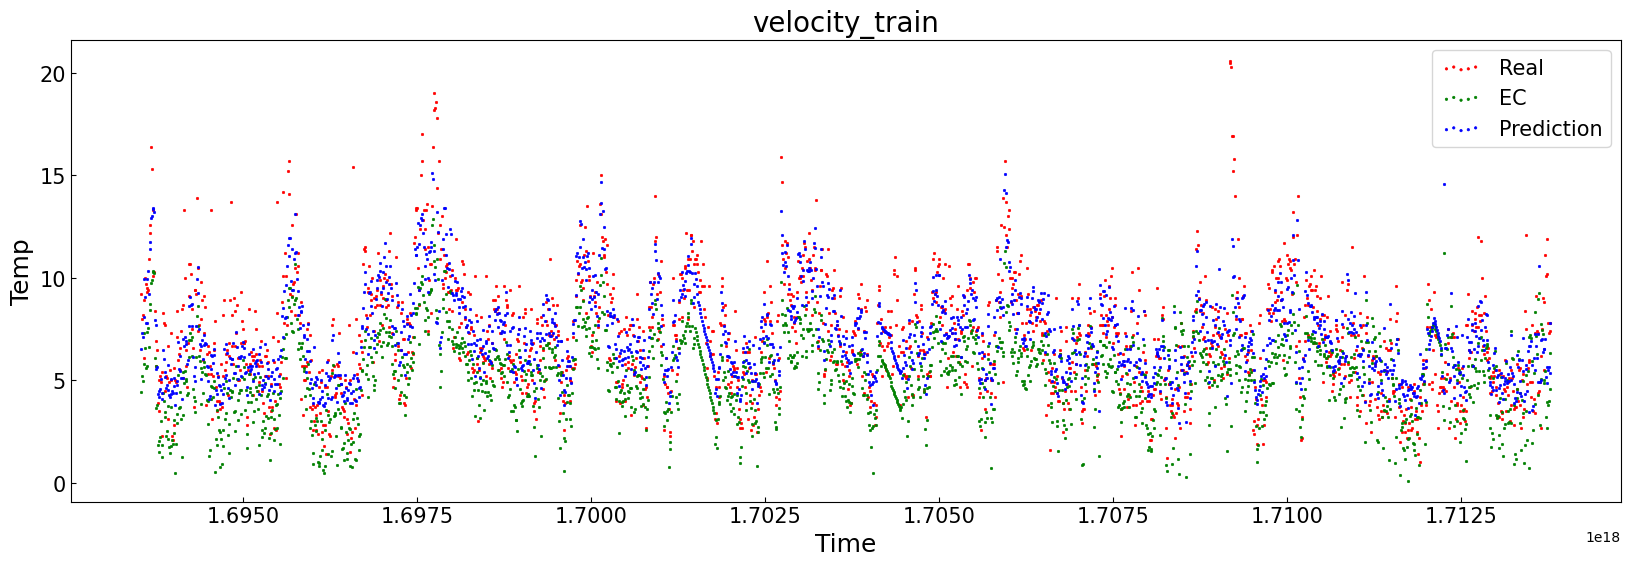

In [41]:
size = 3
line_width = 0.5
# 设置画布大小
figsize = (20, 6)
# 创建画布
plt.figure(figsize = figsize)
## 全局设置
# 绘制第一幅图
plt.scatter(time_train, train_label, s=size, linewidth=line_width, label='Real', color='red')
plt.scatter(time_train, train_feature, s=size, linewidth=line_width, label='EC', color='green')
plt.scatter(time_train, train_prediction, s=size, linewidth=line_width, label='Prediction', color='blue')

plt.tick_params(direction='in', labelsize=15)
plt.ylabel('Temp', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('velocity_train', fontsize=20)
plt.legend(scatterpoints = 5, loc='upper right', fontsize=15)
# plt.savefig('../pic_01/风速插值前后对比图（EC）', dpi=300, bbox_inches='tight')
plt.show()

### 测试集结果

In [39]:
## 训练集上结果
test_feature = feature_test[:, 0].flatten() * (feature_max[0] - feature_min[0]) + feature_min[0]
test_prediction = model(feature_test_tensor).detach().numpy().flatten()
test_label = label_test.flatten()

In [40]:
import pandas as pd
# 将时间转为正常形式
timestamps = time_test 
datetime = pd.to_datetime(timestamps)

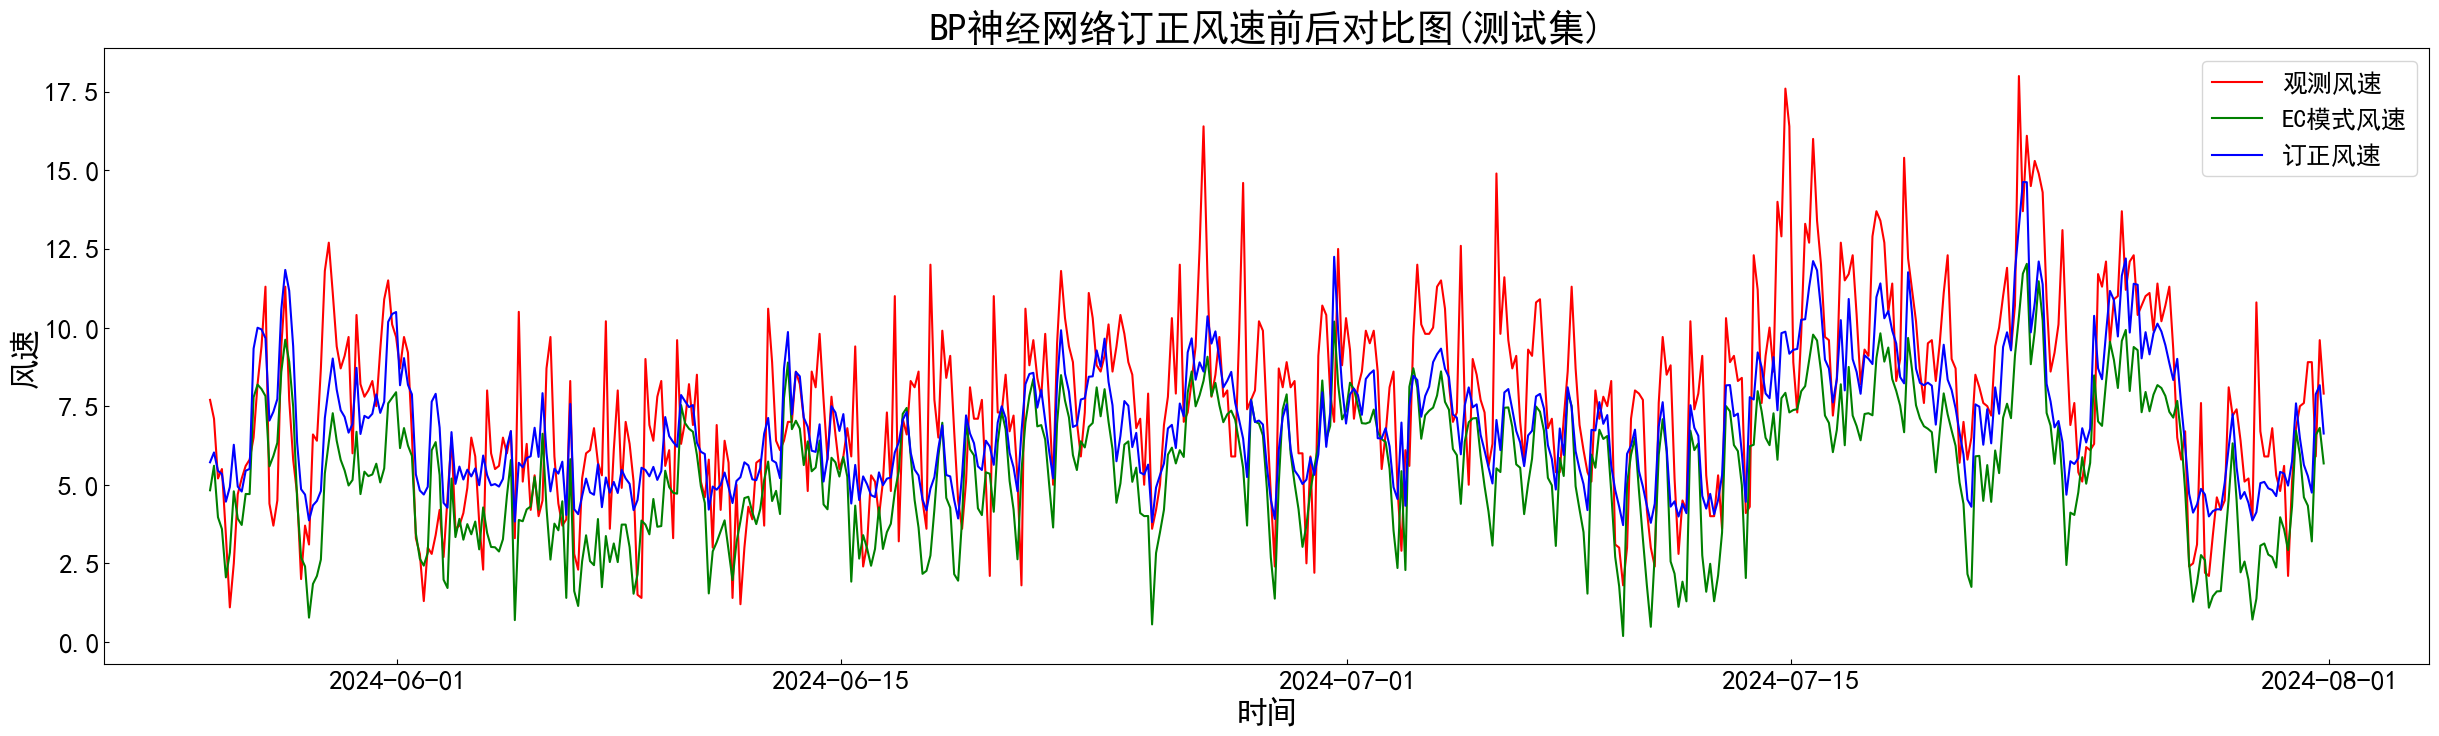

In [42]:
# 设置Matplotlib支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

size = 8
line_width = 1.5

s = 0
e = -1

# 设置画布大小
figsize = (30, 8)
# 创建画布
plt.figure(figsize = figsize)
## 全局设置
# 绘制第一幅图
plt.plot(datetime[s:e], test_label[s:e], color = 'red', linewidth = line_width, label = '观测风速')
plt.plot(datetime[s:e], test_feature[s:e], color = 'green', linewidth = line_width, label = 'EC模式风速')
plt.plot(datetime[s:e], test_prediction[s:e], color = 'blue', linewidth = line_width, label = '订正风速')

plt.tick_params(direction='in', labelsize=20)
plt.ylabel('风速', fontsize=22)
plt.xlabel('时间', fontsize=22)
plt.legend(scatterpoints = 5, loc='upper right',fontsize=18)
plt.title('BP神经网络订正风速前后对比图(测试集)',fontsize=27)
plt.savefig('../pic_01/BP_velocity_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
# RMSE
rmse_model = np.sqrt(np.mean((test_label - test_feature) ** 2))
rmse_prediction = np.sqrt(np.mean((test_label - test_prediction) ** 2))
rmse_diff = rmse_model - rmse_prediction
print('均方根误差', '训练前：', rmse_model, '训练后：', rmse_prediction, '误差降低：', rmse_diff)

均方根误差 训练前： 3.098702 训练后： 2.280129 误差降低： 0.818573


In [44]:
# MAE
mae_model = np.mean(np.abs(test_label - test_feature))
mae_prediction = np.mean(np.abs(test_label - test_prediction))
mae_diff = mae_model - mae_prediction
print('平均绝对误差', '训练前：', mae_model, '训练后：', mae_prediction, '误差降低：', mae_diff)

平均绝对误差 训练前： 2.5645921 训练后： 1.7680168 误差降低： 0.7965753


In [45]:
# PCC
pcc_model = np.corrcoef(test_label, test_feature)[0, 1]
pcc_prediction = np.corrcoef(test_label, test_prediction)[0, 1]
pcc_diff =  pcc_prediction - pcc_model
print('皮尔逊相关系数', '训练前：', pcc_model, '训练后：', pcc_prediction, '相关增加：', pcc_diff)

皮尔逊相关系数 训练前： 0.693241607435652 训练后： 0.6981436455563947 相关增加： 0.004902038120742747
